QKAN for signal/background classification

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
from cirq.contrib.svg import SVGCircuit
import sympy
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [4]:
data = np.load('QIS_EXAM_200Events.npz', allow_pickle=True)
training=data['training_input'].item()
testing=data['test_input'].item()
X_train_bg = training['0']   # background events (label 0)
X_train_sig = training['1']   # signal events (label 1)
X_test_bg  = testing['0']
X_test_sig = testing['1']

In [5]:
X_train = np.concatenate([X_train_bg, X_train_sig], axis=0)
y_train = np.concatenate([np.zeros(len(X_train_bg)), np.ones(len(X_train_sig))], axis=0)
X_test = np.concatenate([X_test_bg, X_test_sig], axis=0)
y_test = np.concatenate([np.zeros(len(X_test_bg)), np.ones(len(X_test_sig))], axis=0)

scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_bg_scaled = scaler.transform(X_train_bg)
X_train_sig_scaled = scaler.transform(X_train_sig)
X_test_bg_scaled = scaler.transform(X_test_bg)
X_test_sig_scaled = scaler.transform(X_test_sig)

n_features = X_train.shape[1]  #5 features

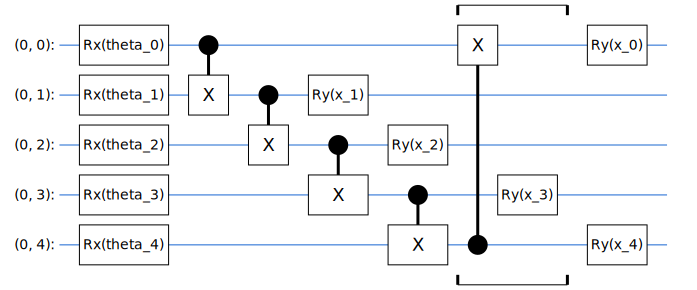

In [15]:
qubits = [cirq.GridQubit(0, i) for i in range(5)]
x_symbols = [sympy.symbols(f'x_{i}') for i in range(5)]
theta_symbols = [sympy.symbols(f'theta_{i}') for i in range(5)]

circuit = cirq.Circuit()
for i, qubit in enumerate(qubits):
    circuit.append(cirq.rx(theta_symbols[i])(qubit))  # Trainable parameters

for i in range(len(qubits) - 1):
    circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))  # Entanglement
circuit.append(cirq.CNOT(qubits[4], qubits[0]))

for i, qubit in enumerate(qubits):
    circuit.append(cirq.ry(x_symbols[i])(qubit))  # another trainable parameters
readout = cirq.Z(qubits[0])
constant_circuit = tfq.convert_to_tensor([circuit])

SVGCircuit(circuit)

In [7]:
#generator
latent_dim = 4
generator_input = tf.keras.layers.Input(shape=(latent_dim,))
gen_dense = tf.keras.layers.Dense(n_features, activation='tanh')(generator_input)
generated_angles = tf.keras.layers.Lambda(lambda x: (x + 1) * (np.pi / 2))(gen_dense)

generator = tf.keras.Model(generator_input, generated_angles)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
generator.compile(optimizer=gen_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
#discriminator
controller = tf.keras.Sequential(
    [tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(32, activation='elu'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(10)])

circuit_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='circuit')
data_input = tf.keras.layers.Input(shape=(5,), dtype=tf.float32, name='classical_input')
dense_2 = controller(data_input)

quantum_layer = tfq.layers.ControlledPQC(
    circuit,
    readout,
    backend=cirq.Simulator(),
    differentiator=tfq.differentiators.ParameterShift()
)

q_out = quantum_layer([circuit_input, dense_2])
# x = tf.keras.layers.Dense(128, activation='relu')(q_out)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(q_out)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
discriminator = tf.keras.Model(inputs=[circuit_input, data_input],
                       outputs=output)

disc_optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4)

discriminator.compile(optimizer=disc_optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [9]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 classical_input (InputLaye  [(None, 5)]                  0         []                            
 r)                                                                                               
                                                                                                  
 circuit (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 10)                   3178      ['classical_input[0][0]']     
                                                                                                  
 controlled_pqc (Controlled  (None, 2)                    0         ['circuit[0][0]',       

In [84]:
bce_loss = tf.keras.losses.BinaryCrossentropy()
batch_size = 16
epochs = 12
n_sig = X_train_sig_scaled.shape[0]
n_bg  = X_train_bg_scaled.shape[0]
best_val_loss = float('inf')
patience = 5
wait = 0

In [85]:
for epoch in range(epochs):
    num_batches = min(n_sig, n_bg) // batch_size
    train_loss = 0

    for _ in range(num_batches):
        sig_indices = np.random.choice(n_sig, batch_size, replace=False)
        bg_indices  = np.random.choice(n_bg, batch_size, replace=False)
        batch_sig = X_train_sig_scaled[sig_indices]
        batch_bg  = X_train_bg_scaled[bg_indices]
        batch_circuits = tf.repeat(constant_circuit, repeats=batch_size, axis=0)

        #update discriminator
        with tf.GradientTape() as tape_disc:
            preds_sig  = discriminator([batch_circuits,batch_sig])
            preds_bg   = discriminator([batch_circuits,batch_bg])
            loss_sig   = bce_loss(tf.ones_like(preds_sig), preds_sig)
            loss_bg    = bce_loss(tf.zeros_like(preds_bg), preds_bg)
            disc_loss  = loss_sig + loss_bg
        gradients_disc = tape_disc.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
        # train_loss += disc_loss.numpy()

        #Update Generator
        with tf.GradientTape() as tape_gen:
            noise = tf.random.normal([batch_size, latent_dim])
            fake_angles = generator(noise)
            batch_circuits = tf.repeat(constant_circuit, repeats=batch_size, axis=0)
            preds_fake = discriminator([batch_circuits,fake_angles])
            gen_loss = bce_loss(tf.ones_like(preds_fake), preds_fake)+0.00001*bce_loss(tf.ones_like(fake_angles), fake_angles)
        # print(tape_gen.watched_variables())
        gradients_gen = tape_gen.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    # Validation Step
    # train_loss /= num_batches
    # val_sig_indices = np.random.choice(len(X_train_sig_scaled), batch_size, replace=False)
    # val_bg_indices  = np.random.choice(len(X_train_bg_scaled), batch_size, replace=False)
    # val_sig = X_train_sig_scaled[val_sig_indices]
    # val_bg  = X_train_bg_scaled[val_bg_indices]

    # val_circuits = tf.repeat(constant_circuit, repeats=batch_size, axis=0)

    # preds_val_sig = discriminator([val_circuits, val_sig])
    # preds_val_bg  = discriminator([val_circuits, val_bg])

    # loss_val_sig = bce_loss(tf.ones_like(preds_val_sig), preds_val_sig)
    # loss_val_bg  = bce_loss(tf.zeros_like(preds_val_bg), preds_val_bg)
    # val_loss = loss_val_sig + loss_val_bg

    # print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early Stopping Check
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     wait = 0
    #     print("Validation loss improved. ")
    #     discriminator.save_weights("best_discriminator.h5")
    # else:
    #     wait += 1
    #     print(f"No improvement in validation loss for {wait}/{patience} epochs.")

    # if wait >= patience:
    #     print("Early stopping triggered!")
    #     discriminator.load_weights("best_discriminator.h5")
    #     break

    print(f"Epoch {epoch}: Discriminator Loss = {disc_loss.numpy():.4f}, Generator Loss = {gen_loss.numpy():.4f}")


Epoch 0: Discriminator Loss = 1.3857, Generator Loss = 0.6886
Epoch 1: Discriminator Loss = 1.3839, Generator Loss = 0.6825
Epoch 2: Discriminator Loss = 1.3730, Generator Loss = 0.6765
Epoch 3: Discriminator Loss = 1.3561, Generator Loss = 0.6589
Epoch 4: Discriminator Loss = 1.3455, Generator Loss = 0.6538
Epoch 5: Discriminator Loss = 1.3152, Generator Loss = 0.6467
Epoch 6: Discriminator Loss = 1.2781, Generator Loss = 0.6286
Epoch 7: Discriminator Loss = 1.2992, Generator Loss = 0.6118
Epoch 8: Discriminator Loss = 1.2637, Generator Loss = 0.5865
Epoch 9: Discriminator Loss = 1.2198, Generator Loss = 0.5889
Epoch 10: Discriminator Loss = 1.1808, Generator Loss = 0.5688
Epoch 11: Discriminator Loss = 1.1603, Generator Loss = 0.5560


In [86]:
test_batch_size = X_test_scaled.shape[0]
test_circuits = tf.repeat(constant_circuit, repeats=test_batch_size, axis=0)

# circ_fake=[circ(X_test_scaled[i]) for i in range(test_batch_size)]
# circ_fake=tf.stack(circ_fake)
test_preds = discriminator([test_circuits,X_test_scaled])
test_preds = tf.squeeze(test_preds).numpy()
test_accuracy = np.mean((test_preds > 0.5) == y_test)
test_auc = roc_auc_score(y_test, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")


Test Accuracy: 0.7200
Test ROC AUC: 0.7820


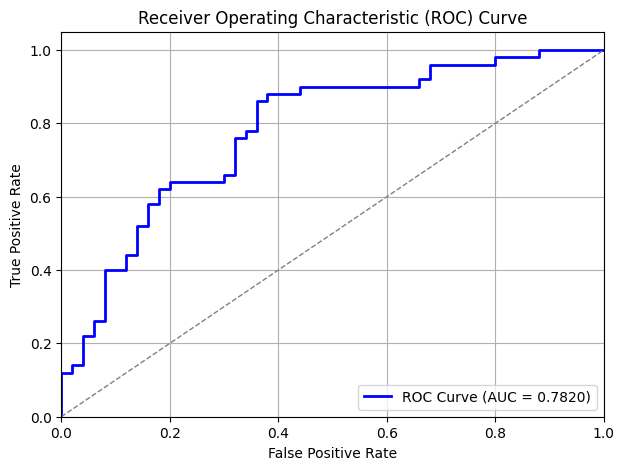

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Note:

I think QGAN is not the best model to use in terms of classification task. Although we can use the generator to generate more training data to train the discriminator to have better understanding of the feature and become more accurate in classification, when I implemented that, I noticed that learning to distinguish real and fake data does not help dimincriminator in seperating signal and background as much. So I decided to focus on fine tuning the discriminator and just use the discriminator to classify background/signal instead of fake/real. However, QGAN is certainly useful to explore. For example we can use QGAN to create an approximate QRAM for quantum neural networks from the paper on EQ-GAN.

Things I considere in fine tuning:


*   Number of trainable parameter layer of quantum circuit
*   Number of layer for classical MLP
*   Parameters for classical MLP, such as drop out rate, batch normalization, or number of layer needed. I reduced the number of layer and added drop out to reduce overfitting
*   Learning rate, batch size, and early stopping



 Some ideas to further fine tune the model:


*   To further reduce overfitting, we can introduce some noise in the training data, or examine the features provided and modify them, or leverage the generator to provide fake training data to help the discriminator learn more underlying trends.
*   Also, we can modify the loss function to increase the confidence of the classification.
*   We can plot the distribution of training data to learn more about each feature and modify the weight of each.


